# Overview

This assignment has a few components and parts as below.

* Shallow vs Deep Network (07a)

* Noise vs non noise input (07a)

* Compute Cross Entropy (07b)

* Explore Stable diffusion and GPT (07c)

I haven't completed the instructions for the assignments. But all the sample outputs are ready as below to give you an idea. Stay tune for more updates!

In [2]:
import time
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
% matplotlib inline

# seed = 7
# torch.manual_seed(seed)
# torch.backends.cudnn.deterministic = True  
# torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
# np.random.seed(seed)

UsageError: Line magic function `%` not found.


In [3]:
#Download Data

transformCustom = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])


train = datasets.MNIST(root='.',train=True,transform=transformCustom, download=True)
test = datasets.MNIST(root='.', train=False, transform=transformCustom,download=True)

#Set DataLoader
batchSize = 128  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test,batch_size=batchSize, shuffle=False) # no need to shuffle test data

# 1. Shallow vs Deep Network

In this assignment we want to see the effect of Shallow vs Deep Networks. Is the Deep Network a magical pill that solves all problems? What type of problems are suitable for Deep Networks? When or How does a Shallow Network be as good as Deep Networks? These are the questions that we will be pondering upon.

### 1.1 Design a few shallow and deep networks. Examples are below.
Below is shown some incomplete code on shallow vs deep vs deeper networks that I have experimented with. You don't have to do exactly the same. But you must compare a few shallow vs deep networks


In [4]:
class Arbitary_NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(Arbitary_NN, self).__init__()
        
        all_layers = []
        
        # Create input layer
        all_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Create hidden layers
        for i in range(len(hidden_sizes) - 1):
            all_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))

        # Create output layer
        all_layers.append(nn.Linear(hidden_sizes[-1], num_classes))
        
        # Store all layers
        self.layers = nn.ModuleList(all_layers)

    def forward(self, x):
        # Pass input through each layer, using ReLU activation function except for the final layer
        for i, layer in enumerate(self.layers):
            if i == len(self.layers) - 1:
                x = layer(x)  # no activation for the final layer
            else:
                x = F.relu(layer(x))
        return x


#essentially NN of any size runs on the same principle as arbitarily defined layers
class ShallowNN(Arbitary_NN): #1 hidden layer
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(ShallowNN,self).__init__(input_size, hidden_sizes, num_classes)

class DeepNN(Arbitary_NN): #2 hidden layers
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(DeepNN,self).__init__(input_size, hidden_sizes, num_classes)

class DeeperNN(Arbitary_NN): #5 hidden layers
  def __init__(self,input_size, hidden_sizes, num_classes):
    super(DeeperNN,self).__init__(input_size, hidden_sizes, num_classes)


### 1.2 Train your Shallow vs Deep Network on the MNIST dataset.

As you can see below, training is a function which takes the dataset to be trained. The 'False' flag is just an indicator whether the input dataset is the noisy or original. Again, you don't have to use the same arguments.

```
model_shallow = ShallowNN(784,128, 10) #input_size,hidden_size,num_classes
model_deep = DeepNN(784,128,128,10) #input_size,hidden_size1,hidden_size2,num_classes
model_deeper = DeeperNN(784,128,16,16,16,16,10) #input_size,hidden_size1,hidden_size2,num_classes


training_shallow_loss =  training(model_shallow,train_loader,10,False)
training_deep_loss =  training(model_deep,train_loader,10,False)
training_deeper_loss =  training(model_deeper,train_loader,10,False)
```

In [5]:
def training(model, data_loader, noisy=False):
    loss_fn = nn.CrossEntropyLoss() 
    opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy-to escape the local minima and to converge quickly
    epochSize = 10 #obviously this isn't enough
    losses = []
    total_time = 0
    
    for epoch in range(epochSize): #this training part can be made into a function, or defined as function of class MLP
        start = time.time()
        loop = tqdm(data_loader)
        loss = 0
        # Load the data 
        for index, (input_batch, target_batch) in enumerate(loop):
            if noisy:
                input_batch = add_noise(input_batch)

            #Zero the gradients
            opt.zero_grad() 
            #Forward pass
            predict_batch = model(input_batch) 
            #Compute loss
            loss_batch = loss_fn(predict_batch,target_batch)  
            #Backward pass and update weights
            loss_batch.backward() #autodifferentiation
            opt.step() #update weights

            loss += loss_batch.item() #store the loss
            
            # add stuff to progress bar in the end
            loop.set_description(f"Epoch [{epoch+1}/{epochSize}]")
            loop.set_postfix(loss=torch.rand(1).item(), acc=torch.rand(1).item())
            
        losses.append(loss)
        end = time.time()
        duration = (end - start)
        total_time += duration
        print(f'Epoch: {epoch+1}  loss: {loss} time: {duration}s')    
    print(f'Total time: {total_time}s')
    return losses


In [6]:
#Output
model_shallow = ShallowNN(784,[128], 10)
model_deep = DeepNN(784,[128,128],10)
model_deeper = DeeperNN(784,[128,16,16,16,16],10)

print('\nTraining Shallow NN:')
training_shallow_loss =  training(model_shallow,train_loader,False)
training_deep_loss =  training(model_deep,train_loader,False)
print('\nTraining Deep NN:')
training_deeper_loss =  training(model_deeper,train_loader,False)
print('\nTraining Deeper NN:')


Training Shallow NN:


Epoch [1/10]: 100%|██████████| 469/469 [00:18<00:00, 25.93it/s, acc=0.587, loss=0.841]   


Epoch: 1  loss: 194.75143621861935 time: 18.095441102981567s


Epoch [2/10]: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s, acc=0.848, loss=0.783]  


Epoch: 2  loss: 90.51030995696783 time: 20.054746627807617s


Epoch [3/10]: 100%|██████████| 469/469 [00:16<00:00, 28.43it/s, acc=0.308, loss=0.405]  


Epoch: 3  loss: 64.92401219531894 time: 16.4983069896698s


Epoch [4/10]: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s, acc=0.871, loss=0.316]  


Epoch: 4  loss: 49.96270867995918 time: 15.500106811523438s


Epoch [5/10]: 100%|██████████| 469/469 [00:17<00:00, 27.56it/s, acc=0.321, loss=0.683]  


Epoch: 5  loss: 40.36606307141483 time: 17.021464347839355s


Epoch [6/10]: 100%|██████████| 469/469 [00:17<00:00, 26.96it/s, acc=0.432, loss=0.649]    


Epoch: 6  loss: 33.675157472491264 time: 17.40009045600891s


Epoch [7/10]: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s, acc=0.664, loss=0.485]   


Epoch: 7  loss: 28.464276605285704 time: 16.26423978805542s


Epoch [8/10]: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s, acc=0.15, loss=0.439]    


Epoch: 8  loss: 23.873825650196522 time: 16.45376420021057s


Epoch [9/10]: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s, acc=0.493, loss=0.529]  


Epoch: 9  loss: 20.13913803640753 time: 16.541507959365845s


Epoch [10/10]: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s, acc=0.514, loss=0.97]    


Epoch: 10  loss: 17.55128894513473 time: 18.93632221221924s
Total time: 172.76599049568176s


Epoch [1/10]: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s, acc=0.935, loss=0.578]   


Epoch: 1  loss: 185.50613541901112 time: 21.202691078186035s


Epoch [2/10]: 100%|██████████| 469/469 [00:23<00:00, 19.96it/s, acc=0.926, loss=0.817]   


Epoch: 2  loss: 75.34201915375888 time: 23.500154733657837s


Epoch [3/10]: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s, acc=0.534, loss=0.222]   


Epoch: 3  loss: 51.63404677435756 time: 15.98666501045227s


Epoch [4/10]: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s, acc=0.867, loss=1]       


Epoch: 4  loss: 38.397170779295266 time: 15.463929176330566s


Epoch [5/10]: 100%|██████████| 469/469 [00:15<00:00, 29.85it/s, acc=0.127, loss=0.409]   


Epoch: 5  loss: 30.561326179653406 time: 15.720753908157349s


Epoch [6/10]: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s, acc=0.254, loss=0.819]   


Epoch: 6  loss: 24.830289473757148 time: 18.8349506855011s


Epoch [7/10]: 100%|██████████| 469/469 [00:19<00:00, 24.37it/s, acc=0.49, loss=0.0854]  


Epoch: 7  loss: 19.432930684182793 time: 19.249691486358643s


Epoch [8/10]: 100%|██████████| 469/469 [00:13<00:00, 34.44it/s, acc=0.925, loss=0.574]   


Epoch: 8  loss: 16.425121125299484 time: 13.625196933746338s


Epoch [9/10]: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s, acc=0.812, loss=0.128]   


Epoch: 9  loss: 13.321932904189453 time: 14.209959030151367s


Epoch [10/10]: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s, acc=0.717, loss=0.997]   


Epoch: 10  loss: 11.050089429074433 time: 14.803236961364746s
Total time: 172.59722900390625s

Training Deep NN:


Epoch [1/10]: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s, acc=0.647, loss=0.0803] 


Epoch: 1  loss: 403.2964127063751 time: 14.199542999267578s


Epoch [2/10]: 100%|██████████| 469/469 [00:13<00:00, 33.63it/s, acc=0.593, loss=0.0672]  


Epoch: 2  loss: 139.2914510667324 time: 13.945385217666626s


Epoch [3/10]: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s, acc=0.605, loss=0.381]  


Epoch: 3  loss: 99.67189468443394 time: 13.794587850570679s


Epoch [4/10]: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s, acc=0.121, loss=0.187]   


Epoch: 4  loss: 79.02510828152299 time: 13.70228123664856s


Epoch [5/10]: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s, acc=0.89, loss=0.388]    


Epoch: 5  loss: 65.10708385147154 time: 13.752026557922363s


Epoch [6/10]: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s, acc=0.313, loss=0.606]  


Epoch: 6  loss: 55.55995797179639 time: 13.746588468551636s


Epoch [7/10]: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s, acc=0.221, loss=0.0758] 


Epoch: 7  loss: 47.63101760111749 time: 13.822816133499146s


Epoch [8/10]: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s, acc=0.889, loss=0.00564]


Epoch: 8  loss: 40.178601462394 time: 13.768275022506714s


Epoch [9/10]: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s, acc=0.752, loss=0.85]    


Epoch: 9  loss: 36.064013230614364 time: 13.739192962646484s


Epoch [10/10]: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s, acc=0.692, loss=0.189]   

Epoch: 10  loss: 31.54731933400035 time: 13.71977972984314s
Total time: 138.19047617912292s

Training Deeper NN:


### Illustrate Cross Entropy with Epoch

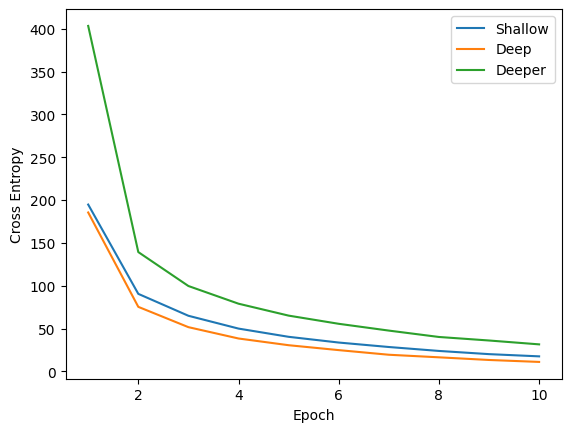

In [7]:
for losses in [training_shallow_loss, training_deep_loss, training_deeper_loss]:
    plt.plot(list(range(1,len(losses)+1)), losses)
plt.legend(['Shallow', 'Deep', 'Deeper'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

### 1.3 Visualize the training loss vs epoch for all shallow vs deep networks

In the figures below, I've played around with the number of neurons in each hidden layers for all of my networks defined earlier, to give you a variety of output.  

You should try to output at least a single figure as below. Better to compare to vary the architecture of the networks to show what is working and what isn't working ('working' defined as in deeper networks outperforms shallow networks).Hopefully the loss went down as the models learned!


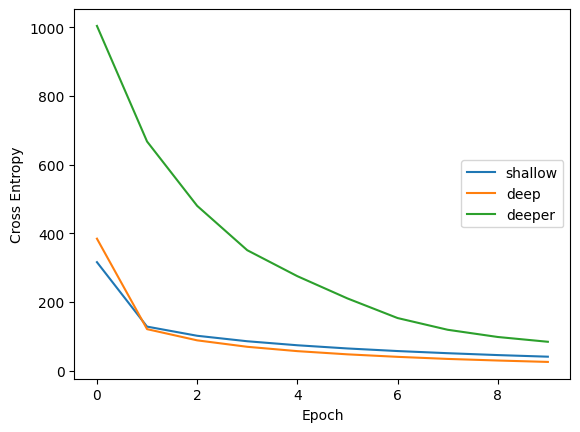

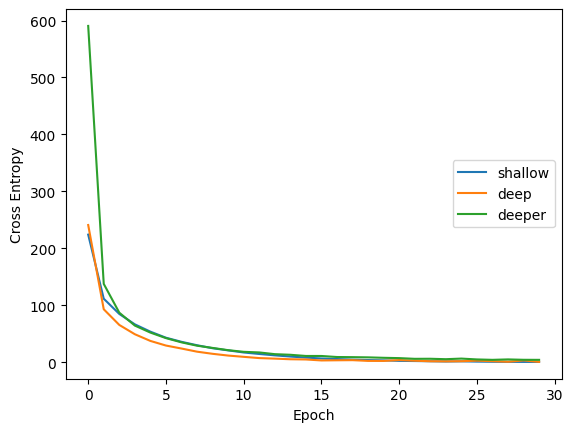

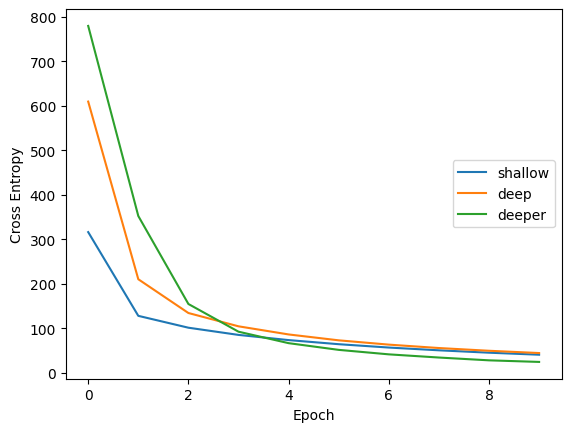

### 1.4 Evaluation of trained model on trained data

Previously we've computed the loss vs epoch. But now we want to evaluate the trained models and their predictions against the training and test dataset. Hence we would need to compute the overall accuracy of the training and test set. Note you need to make a call to model.eval() - this sets the model into evaluation mode and supresses non-training things (gradients, and things such as dropout being applied/computed).

Some samples of the output are given below.


```
print('----Model Shallow-----\n')
evaluate_model(model_shallow,train_loader,test_loader)

print('\n----Model Deep-----')
evaluate_model(model_deep,train_loader,test_loader)

print('\n----Model Deeper-----')
evaluate_model(model_deeper,train_loader,test_loader)
```

In [8]:
#Sample output
def compute_accuracy(model, data_loader):
  total = correct = 0
  model.eval() # sets the model in evaluation mode 
  for input_batch, target_batch in data_loader: #data_loader can take train or test dataset
    predict_batch = model(input_batch)     
    _, predicted = torch.max(predict_batch.data, 1)
    total += target_batch.size(0)
    correct += (predicted == target_batch).sum().item()
  print(f'number of evaluated data: {total}')
  print(f'number of wrongly predicted label: {total - correct}')
  print(f'Accuracy: {100 * correct / total}%')

for model_name, model in [('Shallow NN', model_shallow), ('Deep NN', model_deep), ('Deeper NN', model_deeper)]:
  print(model_name)
  for data_name, data_loader in [('Training Set', train_loader), ('Test Set', test_loader)]:
    print(data_name)
    compute_accuracy(model, data_loader)
  print()



Shallow NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 394
Accuracy: 99.34333333333333%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 220
Accuracy: 97.8%

Deep NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 659
Accuracy: 98.90166666666667%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 261
Accuracy: 97.39%

Deeper NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 970
Accuracy: 98.38333333333334%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 319
Accuracy: 96.81%



# 2. Noisy inputs

In this assignment, we'll be adding noise to the original inputs and see how they affect the performance of the models. Obviously we are expecting the models (regardless shallow or deep networks) to perform relatively poor compared to the original dataset.

### 2.1 Add some noise to the original data and visualize a few of the images

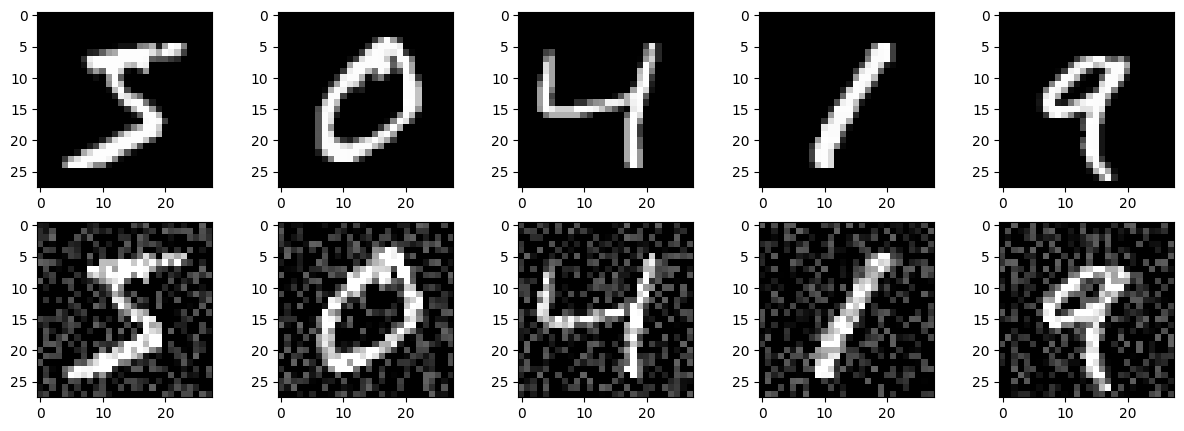

In [9]:
def add_noise(images):
    noisy_images = images + torch.randint(-100, 100, images.size())
    noisy_images = torch.where(noisy_images < 0, 0, noisy_images) #trim below 0
    noisy_images = torch.where(noisy_images > 255, 255, noisy_images) #trim over 255
    return noisy_images

noisy_train = add_noise(train_loader.dataset.data)
# Plot a few images before and after adding noise
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for i in range(5):
    axes[0, i].imshow(train.data[i], cmap='gray')
    axes[1, i].imshow(noisy_train[i], cmap='gray')

plt.show()

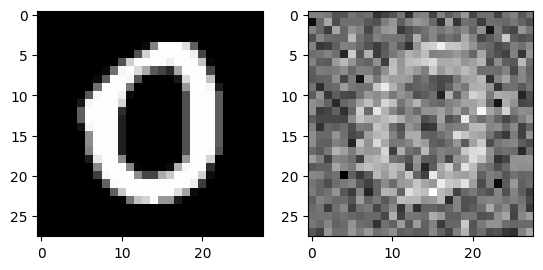

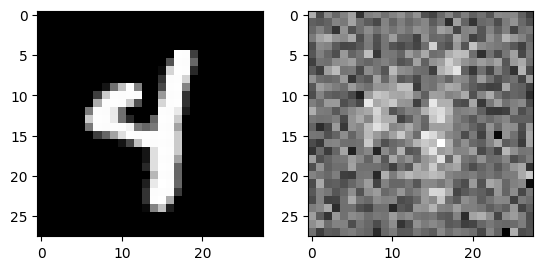

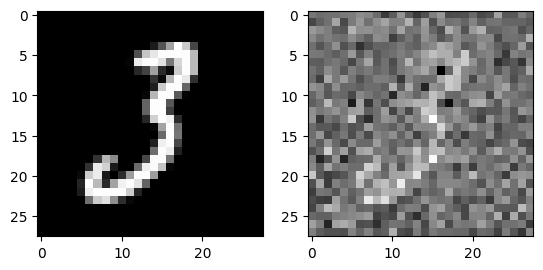

### 2.2 Train some models on the noisy dataset

This stage is the same as the training on the original input. As you might have figured out by now, I'm adding noise to the input as we train instead of creating a noisy dataset first. But that is just me, you can do whatever style and approach you like.

```
model_shallow = ShallowNN(784,128, 10) #input_size,hidden_size,num_classes
model_deep = DeepNN(784,128,128,10) #input_size,hidden_size1,hidden_size2,num_classes
model_deeper = DeeperNN(784,512,312,256,7,784,10) 

training_shallow_loss_noisy =  training(model_shallow,train_loader,10,True)
training_deep_loss_noisy =  training(model_deep,train_loader,10,True)
training_deeper_loss_noisy =  training(model_deeper,train_loader,10,True)
```

In [10]:
print('\nTraining Shallow NN:')
training_shallow_loss_noisy =  training(model_shallow,train_loader,True)
print('\nTraining Deep NN:')
training_deep_loss_noisy =  training(model_deep,train_loader,True)
print('\nTraining Deeper NN:')
training_deeper_loss_noisy =  training(model_deeper,train_loader,True)


Training Shallow NN:


Epoch [1/10]: 100%|██████████| 469/469 [00:14<00:00, 32.55it/s, acc=0.175, loss=0.836]  


Epoch: 1  loss: 27751.50930738449 time: 14.417835235595703s


Epoch [2/10]: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s, acc=0.833, loss=0.959]   


Epoch: 2  loss: 1108.9689455032349 time: 16.433176279067993s


Epoch [3/10]: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s, acc=0.827, loss=0.632]  


Epoch: 3  loss: 1090.711416721344 time: 14.53331732749939s


Epoch [4/10]: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s, acc=0.426, loss=0.923]  


Epoch: 4  loss: 1084.9929628372192 time: 14.585494041442871s


Epoch [5/10]: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s, acc=0.283, loss=0.974]   


Epoch: 5  loss: 1081.5318653583527 time: 14.81465744972229s


Epoch [6/10]: 100%|██████████| 469/469 [00:14<00:00, 31.43it/s, acc=0.792, loss=0.284]    


Epoch: 6  loss: 1080.9504430294037 time: 14.923263311386108s


Epoch [7/10]: 100%|██████████| 469/469 [00:14<00:00, 31.29it/s, acc=0.913, loss=0.847]  


Epoch: 7  loss: 1080.7069218158722 time: 14.992814779281616s


Epoch [8/10]: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s, acc=0.585, loss=0.651]   


Epoch: 8  loss: 1081.4687464237213 time: 14.878558874130249s


Epoch [9/10]: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s, acc=0.952, loss=0.664]   


Epoch: 9  loss: 1080.8315391540527 time: 15.021051168441772s


Epoch [10/10]: 100%|██████████| 469/469 [00:15<00:00, 30.79it/s, acc=0.566, loss=0.547]   


Epoch: 10  loss: 1079.8501319885254 time: 15.244303941726685s
Total time: 149.84447240829468s

Training Deep NN:


Epoch [1/10]: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s, acc=0.973, loss=0.177]    


Epoch: 1  loss: 12862.148668289185 time: 14.625409126281738s


Epoch [2/10]: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s, acc=0.115, loss=0.622]  


Epoch: 2  loss: 1156.8701679706573 time: 16.461315631866455s


Epoch [3/10]: 100%|██████████| 469/469 [00:18<00:00, 25.55it/s, acc=0.116, loss=0.827]   


Epoch: 3  loss: 1127.0021541118622 time: 18.35812282562256s


Epoch [4/10]: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s, acc=0.882, loss=0.17]   


Epoch: 4  loss: 1106.2417285442352 time: 17.773203372955322s


Epoch [5/10]: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s, acc=0.65, loss=0.626]    


Epoch: 5  loss: 1099.7161815166473 time: 17.703423023223877s


Epoch [6/10]: 100%|██████████| 469/469 [00:22<00:00, 21.11it/s, acc=0.318, loss=0.975]   


Epoch: 6  loss: 1090.6878900527954 time: 22.215913772583008s


Epoch [7/10]: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s, acc=0.808, loss=0.796]   


Epoch: 7  loss: 1084.5582048892975 time: 20.987592697143555s


Epoch [8/10]: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s, acc=0.315, loss=0.745]   


Epoch: 8  loss: 1082.2478682994843 time: 21.735053300857544s


Epoch [9/10]: 100%|██████████| 469/469 [00:19<00:00, 24.00it/s, acc=0.153, loss=0.757]   


Epoch: 9  loss: 1081.8015441894531 time: 19.54447650909424s


Epoch [10/10]: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s, acc=0.0132, loss=0.594]  


Epoch: 10  loss: 1081.65953207016 time: 20.090970516204834s
Total time: 189.49548077583313s

Training Deeper NN:


Epoch [1/10]: 100%|██████████| 469/469 [00:22<00:00, 21.01it/s, acc=0.991, loss=0.266]   


Epoch: 1  loss: 36023.76813220978 time: 22.318753004074097s


Epoch [2/10]: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s, acc=0.97, loss=0.712]   


Epoch: 2  loss: 2414.2763950824738 time: 17.464617013931274s


Epoch [3/10]: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s, acc=0.86, loss=0.0238]  


Epoch: 3  loss: 1368.7399463653564 time: 17.11069965362549s


Epoch [4/10]: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s, acc=0.994, loss=0.445]  


Epoch: 4  loss: 1223.4978432655334 time: 17.0400710105896s


Epoch [5/10]: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s, acc=0.392, loss=0.8]     


Epoch: 5  loss: 1190.1497015953064 time: 17.34484362602234s


Epoch [6/10]: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s, acc=0.321, loss=0.599]   


Epoch: 6  loss: 1168.9813063144684 time: 17.435238122940063s


Epoch [7/10]: 100%|██████████| 469/469 [00:18<00:00, 25.25it/s, acc=0.454, loss=0.391]  


Epoch: 7  loss: 1147.5095291137695 time: 18.571241855621338s


Epoch [8/10]: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s, acc=0.0413, loss=0.512]  


Epoch: 8  loss: 1132.5781619548798 time: 17.178916692733765s


Epoch [9/10]: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s, acc=0.701, loss=0.119]  


Epoch: 9  loss: 1121.120980501175 time: 17.461163759231567s


Epoch [10/10]: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s, acc=0.471, loss=0.0568]  

Epoch: 10  loss: 1096.954050064087 time: 17.280067205429077s
Total time: 179.2056119441986s


### 2.3 Visualization of the training loss for noisy input

In this visualization, I compared the performance of shallow vs deep networks for noisy data. And I also compared the performance of all models to see the effect of noisy and original data. 

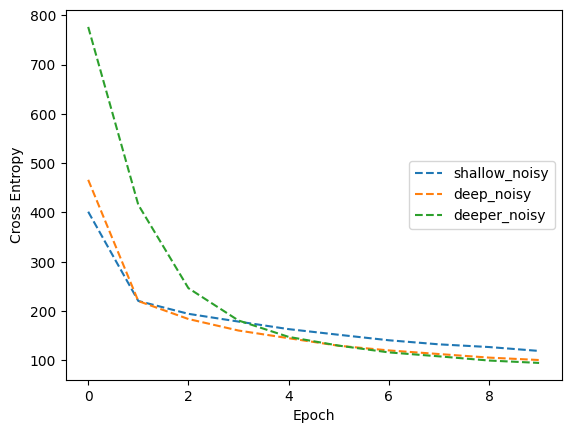

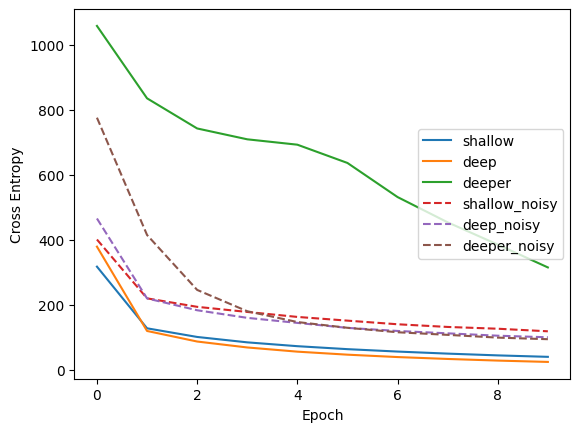

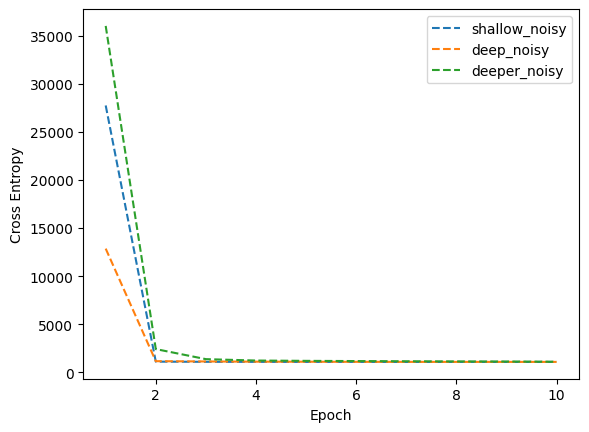

In [11]:
for losses in [training_shallow_loss_noisy, training_deep_loss_noisy, training_deeper_loss_noisy]:
    # #OPTIONAL: trim vals over 1000
    # y = []
    # for val in losses:
    #     y.append(min(val, 1000)) 
    # plt.plot(list(range(1,len(losses)+1)), y, '--')
    plt.plot(list(range(1,len(losses)+1)), losses, '--')
plt.legend(['shallow_noisy', 'deep_noisy', 'deeper_noisy'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

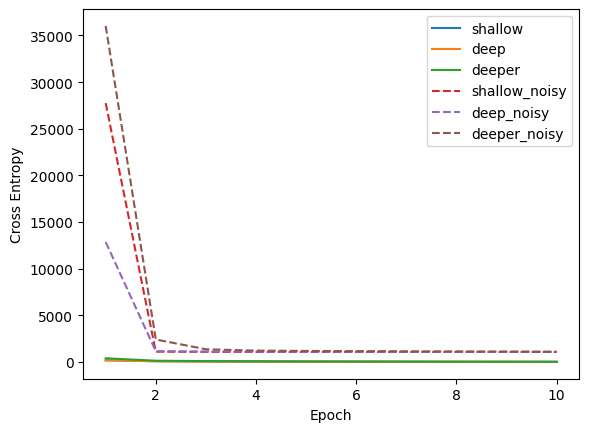

In [12]:
for losses in [training_shallow_loss, training_deep_loss, training_deeper_loss]:
    plt.plot(list(range(1,len(losses)+1)), losses)
for losses in [training_shallow_loss_noisy, training_deep_loss_noisy, training_deeper_loss_noisy]:
    
    plt.plot(list(range(1,len(losses)+1)), losses, '--')
plt.legend(['shallow', 'deep', 'deeper', 'shallow_noisy', 'deep_noisy', 'deeper_noisy'])
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()

### 2.4 Evaluation against training and test dataset

This is also the same as Part 1. Only we expect the model accuracy to be poorer for noisy input compared to the original images.

In [13]:
for model_name, model in [('Shallow NN', model_shallow), ('Deep NN', model_deep), ('Deeper NN', model_deeper)]:
  print(model_name)
  for data_name, data_loader in [('Training Set', train_loader), ('Test Set', test_loader)]:
    print(data_name)
    compute_accuracy(model, data_loader)
  print()



Shallow NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 20796
Accuracy: 65.34%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 3562
Accuracy: 64.38%

Deep NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 16395
Accuracy: 72.675%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 2888
Accuracy: 71.12%

Deeper NN
Training Set
number of evaluated data: 60000
number of wrongly predicted label: 32449
Accuracy: 45.91833333333334%
Test Set
number of evaluated data: 10000
number of wrongly predicted label: 5472
Accuracy: 45.28%



# 3. Cross Entropy between Original input and Noisy input

### 3.1 

Assume that the original input is the 'ground truth' and the noisy input is your probabilistic model of the MNIST images. What is the cross entropy between these two distribution by class?

In this assignment, we assume only the training data represents the ground truth for handwritten digits. This means that all 7~8 billion people of the world, would only write handwritten digits in the style captured by the 60,000 images of the training data. So this training data represents our ground truth.

Now imagine if the 60,000 images of the training data is added noise and corruptied to some point. (Of course how 'corrupt' you want the images to be is up to you. You can try different level of corruptness.)

To make your/our lives easier, we'll just look at the digit 'zero'. So all 7-8 billion people of the world, write the number 'zero' in the style captured by the images of 'zero' in the training data. Careful, the amount of images zero in the training data is obviously not 60,000.


So first, create a dataset of images 'zero' with noise added. Here the original images of zero is labelled as 'image0' and the corrupted ones as 'image0_noisy'. Please visualize the first (or the first few) original images and noisy images as below.  


```

plt.subplot(1,2,1)
show_flattened_image(image0[0])

plt.subplot(1,2,2)
show_flattened_image(image0_noisy[0])

```

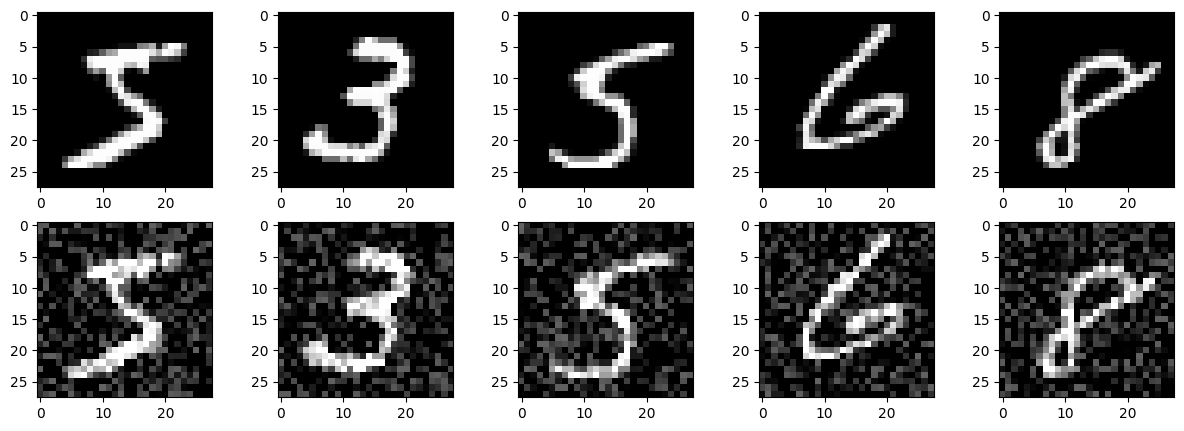

In [38]:
#Sample output
noisy_train = add_noise(train.data)
# Plot a few images before and after adding noise
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
for i in range(0,-5,-1):
    axes[0, i].imshow(train.data[i], cmap='gray')
    axes[1, i].imshow(noisy_train[i], cmap='gray')

plt.show()

### 3.2 Compute probability distribution

Next we need to compute the probability distribution for both image0 and image0_noisy. For an image, we know that each pixel can take the values of 0~255. Let's think, for example, what is the probability that the value 255 occurs in our data(data= image0, image0_noisy)?

So we need to count how many times the value 255 occurs in ALL OF OUR IMAGES. And then we normalized the number of counts to probabilities. 

Below is shown the probability distribution where x-axis is the values 0~255 and y-axis is the probability value. The upper figure is the probability distribution for the orignal image, image0 and the lower figure is the probability distribution for the noisy images or image0_noisy. The value 0 has the highest probability because there are lots of 'dark' areas in all images. This is true regardless of the number anyway.

```

probability_dist = compute_probability(image0)

probability_dist_noisy = compute_probability(image0_noisy)
```


In [99]:
def compute_probability(image):
    dist = torch.empty(256)
    total = torch.numel(image)
    for i in range(256):
        mask = (image == i)
        dist[i] = len(image[mask]) / total
    return dist

Digit 0 matrix shape: torch.Size([5923, 28, 28])
Digit 1 matrix shape: torch.Size([6742, 28, 28])
Digit 2 matrix shape: torch.Size([5958, 28, 28])
Digit 3 matrix shape: torch.Size([6131, 28, 28])
Digit 4 matrix shape: torch.Size([5842, 28, 28])
Digit 5 matrix shape: torch.Size([5421, 28, 28])
Digit 6 matrix shape: torch.Size([5918, 28, 28])
Digit 7 matrix shape: torch.Size([6265, 28, 28])
Digit 8 matrix shape: torch.Size([5851, 28, 28])
Digit 9 matrix shape: torch.Size([5949, 28, 28])


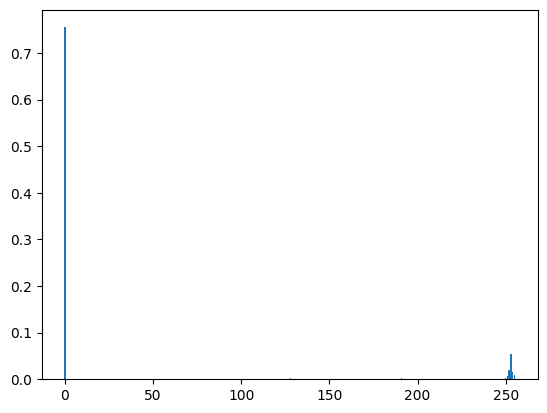

In [100]:
#sort train set into classes
sorted_train = {}
for i in range(10):
    mask = (train.targets == i)
    sorted_train[i] = train.data[mask]
    print(f"Digit {i} matrix shape: {sorted_train[i].shape}")
    
#get all class=0 images   
image0 = sorted_train[0]
dist = compute_probability(image0)
plt.bar(list(range(256)), dist)
plt.show()

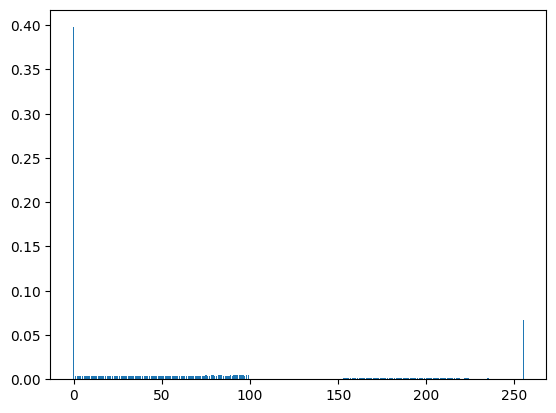

In [102]:
image0_noisy = add_noise(image0)
dist_noisy = compute_probability(image0_noisy)
plt.bar(list(range(256)), dist_noisy)
plt.show()

### 3.3 Compute Cross Entropy distribution 

Now that we have the probabily distribution for the original image0 and corrupted images, image0_noisy, we can compute the Cross Entropy distribution defined as

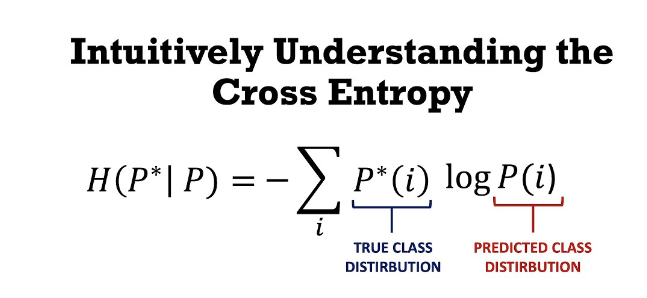

Here P*(i) is the image0 distribution with green bars and  P(i) is the image0_noisy distribution with blue bars. 

Without summation and mutliplication by -1 operation, we can get a distribution of Cross Entropy as the figure below.

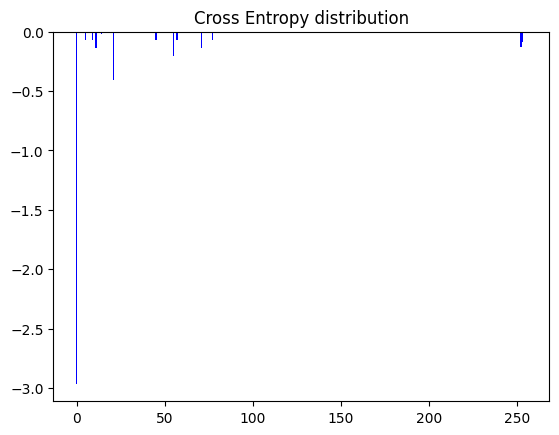

Lastly, we need to just sum up and multiply by -1 to get the total cross entropy.

Total Cross Entropy : 2.315743923187256


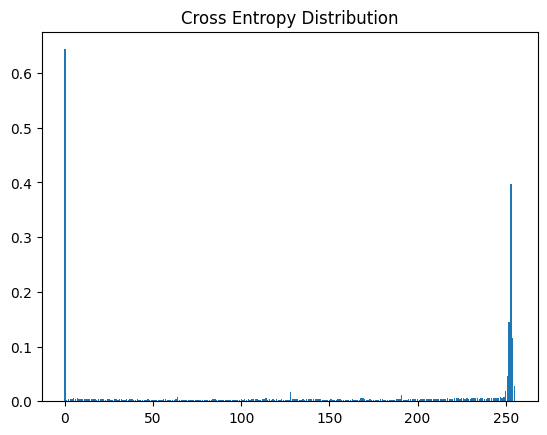

In [110]:
#Cross entropy between original and noisy distribution
dist_noisy += 1e-10
entropy = -1 * dist * torch.log(dist_noisy)

print(f'Total Cross Entropy : {torch.sum(entropy)}')
plt.bar(list(range(256)), entropy)
plt.title('Cross Entropy Distribution')
plt.show()

### Side-by-Side Comparison of Clean, Noisy and Cross Entropy 

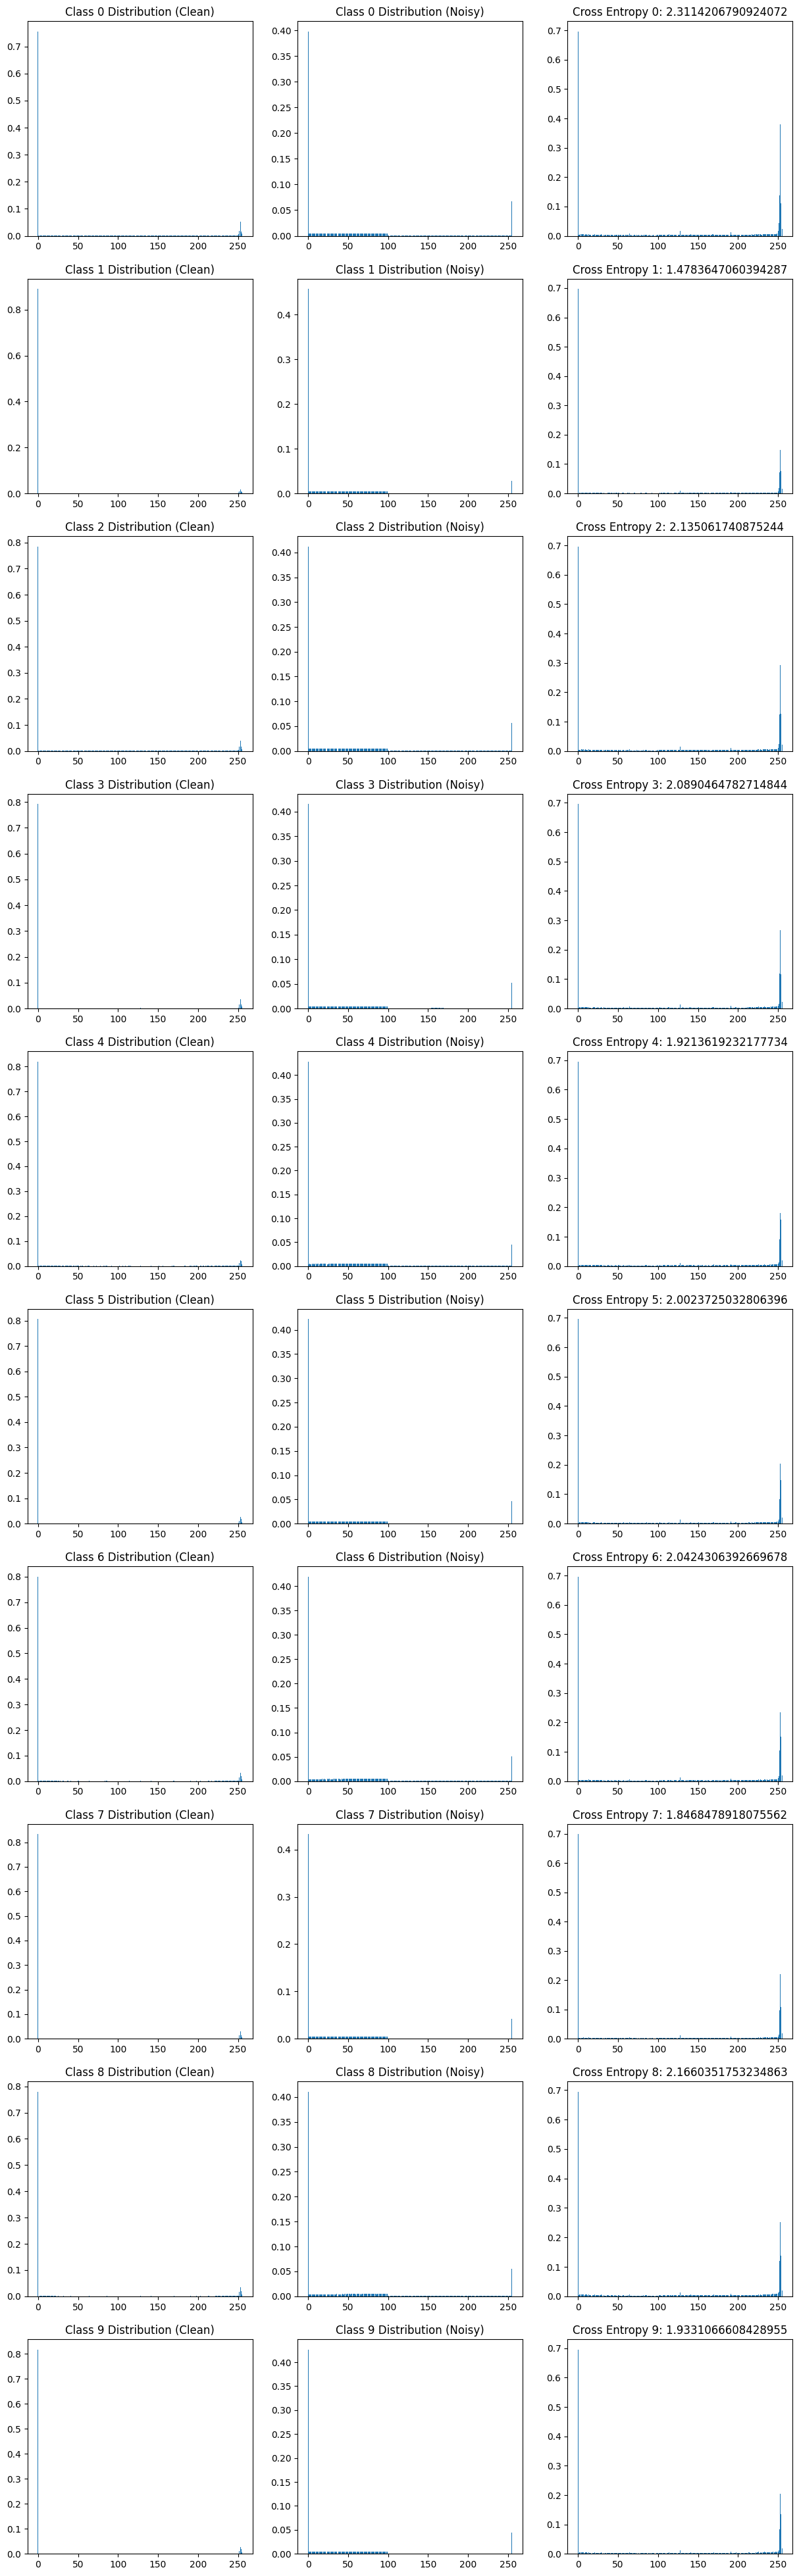

{0: {'clean': tensor([7.5513e-01, 5.6120e-04, 7.6513e-04, 8.4610e-04, 8.9154e-04, 9.4473e-04,
          8.9004e-04, 9.8005e-04, 7.8128e-04, 8.9004e-04, 8.0863e-04, 8.5644e-04,
          7.7827e-04, 9.2234e-04, 6.7447e-04, 7.4812e-04, 6.6521e-04, 6.4239e-04,
          5.9242e-04, 8.1983e-04, 7.6147e-04, 8.4029e-04, 6.3808e-04, 5.3127e-04,
          6.3980e-04, 7.7181e-04, 5.6378e-04, 5.9178e-04, 7.0505e-04, 8.7625e-04,
          5.6551e-04, 7.2896e-04, 8.2112e-04, 4.0981e-04, 5.0112e-04, 6.5681e-04,
          5.4871e-04, 6.8266e-04, 6.5961e-04, 4.2811e-04, 5.1145e-04, 6.3636e-04,
          5.8338e-04, 5.1468e-04, 3.9344e-04, 5.5560e-04, 4.0529e-04, 6.5811e-04,
          5.3665e-04, 4.3048e-04, 5.3385e-04, 5.9587e-04, 3.3874e-04, 4.8087e-04,
          4.4426e-04, 3.9086e-04, 6.7404e-04, 8.1466e-04, 3.2087e-04, 4.6558e-04,
          4.6709e-04, 4.2833e-04, 5.3536e-04, 6.4346e-04, 1.4260e-03, 4.0055e-04,
          4.5417e-04, 4.0464e-04, 3.9753e-04, 3.4908e-04, 4.4534e-04, 5.0392e-04,
    

In [114]:
#get all images   
distribution = {i:{} for i in range(10)}
dim = 5
fig, ax = plt.subplots(nrows=10, ncols=3, figsize=(3*dim, 10*dim))
x_axis = list(range(256))
for i, image in sorted_train.items():
    #clean image
    dist_clean = compute_probability(image)
    distribution[i]['clean'] = dist_clean
    ax[i, 0].bar(x_axis, dist_clean)
    ax[i, 0].set_title(f'Class {i} Distribution (Clean)')
    
    #noisy image
    image_noisy = add_noise(image)
    dist_noisy = compute_probability(image_noisy)
    distribution[i]['noisy'] = dist_noisy
    ax[i, 1].bar(x_axis, dist_noisy)
    ax[i, 1].set_title(f'Class {i} Distribution (Noisy)')
    
    #cross entropy
    dist_noisy += 1e-10
    entropy = -1 * dist_clean * torch.log(dist_noisy)
    distribution[i]['entropy'] = entropy
    ax[i, 2].bar(x_axis, entropy)
    ax[i, 2].set_title(f'Cross Entropy {i}: {torch.sum(entropy)}')

plt.show()
distribution